In [1]:
import scipy.io as spio
import numpy as np

X = spio.loadmat(file_name='../data/bci-sample-data/x.mat')
Y = spio.loadmat(file_name='../data/bci-sample-data/y.mat')

Data = X['Intensification_Data']
SType = Y['Intensification_SType'].mean(axis=1)

print(Data.shape, SType.shape, Data.dtype, SType.dtype)

# 30 % total data test
# 70 % total data train+valid
length = int(Data.shape[0] * 0.30)
# length

TrainDataAll = Data[:-length]
TestData = Data[-length:]

print(TrainDataAll.shape, TestData.shape)

# 30% total train data is valid
# 70% total trainALl is training
length2 = int(TrainDataAll.shape[0] * 0.30)
# length2

TrainData = TrainDataAll[:-length2]
ValidData = TrainDataAll[-length2:]

print(TrainData.shape, ValidData.shape)

# Normalizing input data
def normalize(inputs):
    return (inputs - inputs.mean(axis=0)[None,:,:]) / inputs.std(axis=0)[None,:,:]

# onehot vectorizing output labels
def one_hot(labels, n_class):
    """ One-hot encoding """
    expansion = np.eye(n_class)
    y = expansion[:, labels-1].T
    assert y.shape[1] == n_class, "Wrong number of labels!"

    return y

# get minibatches for learning
def get_batches(X, y, batch_size):
    """ Return a generator for batches """
    n_batches = len(X) // batch_size
    X, y = X[:n_batches*batch_size], y[:n_batches*batch_size]

    # Loop over batches and yield
    for b in range(0, len(X), batch_size):
        yield X[b:b+batch_size], y[b:b+batch_size]

# Standardize/normalize train and test
X_train_norm = normalize(inputs=TrainData)
X_valid_norm = normalize(inputs=ValidData)
X_test_norm = normalize(inputs=TestData)

print(X_train_norm.shape, X_train_norm.dtype, 
X_valid_norm.shape, X_valid_norm.dtype,
X_test_norm.shape, X_test_norm.dtype)

LabelsAll = SType[:]
TrainLabelsAll = SType[:-length]
TestLabels = SType[-length:]

print(LabelsAll.shape, TrainLabelsAll.shape, TestLabels.shape)

TrainLabels = TrainLabelsAll[:-length2]
ValidLabels = TrainLabelsAll[-length2:]

print(TrainLabels.shape, ValidLabels.shape)

Y_train = np.array(TrainLabels, dtype=int)
Y_valid = np.array(ValidLabels, dtype=int)
Y_test = np.array(TestLabels, dtype=int)

print(Y_train.shape, Y_train.dtype, 
Y_test.shape, Y_test.dtype,
Y_valid.shape, Y_valid.dtype)

### Hyperparameters

# CNN hyper parameters
# Input data
batch_size = X_train_norm.shape[0]// 100 # minibatch size & number of minibatches
seq_len = X_train_norm.shape[1] # Number of steps: each trial length
n_channels = X_train_norm.shape[2] # number of channels in each trial

# Output labels
n_classes = int(LabelsAll.max() + 1)

# Tweekable parameters
learning_rate = 0.001 #1e-3
epochs = 10 # num iterations for updating model
keep_prob = 0.50 # 90% neurons are kept and 10% are dropped out

Y_train_onehot = one_hot(labels=Y_train, n_class=n_classes)
Y_valid_onehot = one_hot(labels=Y_valid, n_class=n_classes)
Y_test_onehot = one_hot(labels=Y_test, n_class=n_classes)

print(Y_train_onehot.shape, Y_valid_onehot.shape, Y_test_onehot.shape,
 X_train_norm.shape, X_valid_norm.shape, X_test_norm.shape)

# GPUs availability or CPU

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

#  No graphs is needed on tensorflow
inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs_')
labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels_')
keep_prob_ = tf.placeholder(tf.float32, name = 'keep_prob_')
learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate_')

(6480, 192, 64) (6480,) float64 float64
(4536, 192, 64) (1944, 192, 64)
(3176, 192, 64) (1360, 192, 64)
(3176, 192, 64) float64 (1360, 192, 64) float64 (1944, 192, 64) float64
(6480,) (4536,) (1944,)
(3176,) (1360,)
(3176,) int64 (1944,) int64 (1360,) int64
(3176, 2) (1360, 2) (1944, 2) (3176, 192, 64) (1360, 192, 64) (1944, 192, 64)
TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


In [2]:
# Convolutional Layers, FC Layer, and Output layer
# (batch, 192, 64) --> (batch, 94, 128)
# (192 - 6 + 0)/2 + 1 = (186/2)+1= 93+1= 94
# (2/6)==(1/3) with strides/kernel_size is 33.333% non-overlap/diff region and 
# 66.666% overlapping window/ common region
in_conv = inputs_
out_conv = tf.layers.conv1d(inputs=in_conv, filters=128, kernel_size=6, strides=2, padding='valid')
out_conv = tf.layers.batch_normalization(inputs=out_conv)
out_conv = tf.nn.relu(features=out_conv)
out_conv = tf.nn.dropout(x=out_conv, keep_prob=keep_prob_)
print(out_conv.shape)

# (batch, 94, 128) --> (batch, 45, 256)
# (94 - 6 + 0)/2 + 1 = (88/2)+1= 44+1= 45
# (2/6)==(1/3) with strides/kernel_size is 33.333% non-overlap/diff region and 
# 66.666% overlapping window/ common region
in_conv = out_conv
out_conv = tf.layers.conv1d(inputs=in_conv, filters=256, kernel_size=6, strides=2, padding='valid')
out_conv = tf.layers.batch_normalization(inputs=out_conv)
out_conv = tf.nn.relu(features=out_conv)
out_conv = tf.nn.dropout(x=out_conv, keep_prob=keep_prob_)
print(out_conv.shape)

# (batch, 45, 256) --> (batch, 45*256) --> (batch, 45*256*2)
in_fc = tf.reshape(tensor=out_conv, shape=(-1, 45*256))
out_fc = tf.layers.dense(inputs=in_fc, units=45*256*2)
out_fc = tf.layers.batch_normalization(inputs=out_fc)
out_fc = tf.nn.relu(features=out_fc)
out_fc = tf.nn.dropout(x=out_fc, keep_prob=keep_prob_)
print(in_fc.shape, out_fc.shape)

# (batch, 49*64*2) --> (batch, 2) 
logits = tf.layers.dense(inputs=out_fc, units=n_classes)
print(logits.shape)

(?, 94, 128)
(?, 45, 256)
(?, 11520) (?, 23040)
(?, 2)


In [3]:
# Cost function
cost_tensor = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_)
cost = tf.reduce_mean(input_tensor=cost_tensor)

# Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate_).minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

In [4]:
### Train the network
# Plotting the acc and loss curve
train_acc = []
train_loss = []

valid_acc = []
valid_loss = []

with tf.Session() as sess:
    # initalize session global variables just in the case they are initialized.
    sess.run(tf.global_variables_initializer())
    
    for e in range(epochs):
       
        # Loop over batches
        for x, y in get_batches(X_train_norm, Y_train_onehot, batch_size):
            
            # Feed dictionary
            feed = {inputs_:x, labels_:y, keep_prob_:keep_prob, learning_rate_:learning_rate}
            loss, _ , acc = sess.run([cost, optimizer, accuracy], feed_dict = feed)
            
            train_acc.append(acc)
            train_loss.append(loss)
            
            ################################ Validation
            # Initialize 
            loss_v_batch, acc_v_batch = [], []

            # Loop over batches
            for x_v, y_v in get_batches(X_valid_norm, Y_valid_onehot, batch_size):

                # Feed dictionary
                feed = {inputs_:x_v, labels_:y_v, keep_prob_:1.0}
                loss_v, acc_v = sess.run([cost, accuracy], feed_dict = feed)
                
                acc_v_batch.append(acc_v)
                loss_v_batch.append(loss_v)
                
            valid_acc.append(np.mean(acc_v_batch))
            valid_loss.append(np.mean(loss_v_batch))
            
            # Print info
            print("Epoch: {}/{}".format(e+1, epochs),
                  "Train loss: {:6f}".format(loss),
                  "Valid loss: {:.6f}".format(np.mean(valid_loss)),
                  "Train acc: {:6f}".format(acc),
                  "Valid acc: {:.6f}".format(np.mean(valid_acc)))
            
    ################################ Test
    # Initialize 
    acc_batch, loss_batch = [], []

    # Loop over batches
    for x, y in get_batches(X_test_norm, Y_test_onehot, batch_size):

        # Feed dictionary
        feed = {inputs_:x, labels_:y, keep_prob_:1.0}
        loss, acc = sess.run([cost, accuracy], feed_dict = feed)

        acc_batch.append(acc)
        loss_batch.append(loss)

    # Print info
    print("Epoch: {}/{}".format(e+1, epochs),
          "Test loss: {:6f}".format(np.mean(loss_batch)),
          "Test acc: {:6f}".format(np.mean(acc_batch)))

Epoch: 1/10 Train loss: 1.212925 Valid loss: 39.670612 Train acc: 0.419355 Valid acc: 0.833458
Epoch: 1/10 Train loss: 97.321121 Valid loss: 32.678665 Train acc: 0.806452 Valid acc: 0.833458
Epoch: 1/10 Train loss: 58.111832 Valid loss: 25.682856 Train acc: 0.806452 Valid acc: 0.833458
Epoch: 1/10 Train loss: 15.701215 Valid loss: 20.349094 Train acc: 0.870968 Valid acc: 0.833458
Epoch: 1/10 Train loss: 10.034811 Valid loss: 16.515396 Train acc: 0.806452 Valid acc: 0.833458
Epoch: 1/10 Train loss: 2.706568 Valid loss: 13.877476 Train acc: 0.870968 Valid acc: 0.788197
Epoch: 1/10 Train loss: 1.271901 Valid loss: 12.119920 Train acc: 0.806452 Valid acc: 0.701104
Epoch: 1/10 Train loss: 0.850224 Valid loss: 10.802660 Train acc: 0.516129 Valid acc: 0.634752
Epoch: 1/10 Train loss: 1.954910 Valid loss: 9.740643 Train acc: 0.161290 Valid acc: 0.583062
Epoch: 1/10 Train loss: 2.923816 Valid loss: 8.853546 Train acc: 0.161290 Valid acc: 0.543436
Epoch: 1/10 Train loss: 0.994185 Valid loss: 8.1

Epoch: 1/10 Train loss: 0.379939 Valid loss: 1.468244 Train acc: 0.870968 Valid acc: 0.794752
Epoch: 1/10 Train loss: 0.425338 Valid loss: 1.457146 Train acc: 0.838710 Valid acc: 0.795182
Epoch: 1/10 Train loss: 0.514423 Valid loss: 1.446270 Train acc: 0.838710 Valid acc: 0.795603
Epoch: 1/10 Train loss: 0.489231 Valid loss: 1.435620 Train acc: 0.838710 Valid acc: 0.796014
Epoch: 1/10 Train loss: 0.492489 Valid loss: 1.425187 Train acc: 0.806452 Valid acc: 0.796417
Epoch: 1/10 Train loss: 0.435183 Valid loss: 1.414961 Train acc: 0.870968 Valid acc: 0.796811
Epoch: 1/10 Train loss: 0.479688 Valid loss: 1.404938 Train acc: 0.806452 Valid acc: 0.797197
Epoch: 1/10 Train loss: 0.440341 Valid loss: 1.395110 Train acc: 0.838710 Valid acc: 0.797574
Epoch: 1/10 Train loss: 0.477896 Valid loss: 1.385480 Train acc: 0.838710 Valid acc: 0.797944
Epoch: 1/10 Train loss: 0.470655 Valid loss: 1.376048 Train acc: 0.838710 Valid acc: 0.798307
Epoch: 1/10 Train loss: 0.513425 Valid loss: 1.366810 Train 

Epoch: 2/10 Train loss: 0.408402 Valid loss: 0.966962 Train acc: 0.870968 Valid acc: 0.813996
Epoch: 2/10 Train loss: 0.435837 Valid loss: 0.964082 Train acc: 0.838710 Valid acc: 0.814105
Epoch: 2/10 Train loss: 0.532720 Valid loss: 0.961238 Train acc: 0.806452 Valid acc: 0.814213
Epoch: 2/10 Train loss: 0.428958 Valid loss: 0.958428 Train acc: 0.838710 Valid acc: 0.814320
Epoch: 2/10 Train loss: 0.482428 Valid loss: 0.955650 Train acc: 0.806452 Valid acc: 0.814426
Epoch: 2/10 Train loss: 0.398194 Valid loss: 0.952901 Train acc: 0.870968 Valid acc: 0.814530
Epoch: 2/10 Train loss: 0.427921 Valid loss: 0.950180 Train acc: 0.838710 Valid acc: 0.814634
Epoch: 2/10 Train loss: 0.551352 Valid loss: 0.947490 Train acc: 0.806452 Valid acc: 0.814736
Epoch: 2/10 Train loss: 0.413438 Valid loss: 0.944833 Train acc: 0.838710 Valid acc: 0.814837
Epoch: 2/10 Train loss: 0.459278 Valid loss: 0.942210 Train acc: 0.838710 Valid acc: 0.814938
Epoch: 2/10 Train loss: 0.452321 Valid loss: 0.939615 Train 

Epoch: 3/10 Train loss: 0.523467 Valid loss: 0.798309 Train acc: 0.806452 Valid acc: 0.820459
Epoch: 3/10 Train loss: 0.402340 Valid loss: 0.797004 Train acc: 0.870968 Valid acc: 0.820508
Epoch: 3/10 Train loss: 0.460357 Valid loss: 0.795712 Train acc: 0.806452 Valid acc: 0.820556
Epoch: 3/10 Train loss: 0.382069 Valid loss: 0.794433 Train acc: 0.870968 Valid acc: 0.820604
Epoch: 3/10 Train loss: 0.489432 Valid loss: 0.793161 Train acc: 0.806452 Valid acc: 0.820652
Epoch: 3/10 Train loss: 0.445129 Valid loss: 0.791900 Train acc: 0.838710 Valid acc: 0.820700
Epoch: 3/10 Train loss: 0.497755 Valid loss: 0.790649 Train acc: 0.806452 Valid acc: 0.820747
Epoch: 3/10 Train loss: 0.408595 Valid loss: 0.789405 Train acc: 0.870968 Valid acc: 0.820793
Epoch: 3/10 Train loss: 0.438680 Valid loss: 0.788169 Train acc: 0.838710 Valid acc: 0.820840
Epoch: 3/10 Train loss: 0.551217 Valid loss: 0.786943 Train acc: 0.806452 Valid acc: 0.820886
Epoch: 3/10 Train loss: 0.442425 Valid loss: 0.785727 Train 

Epoch: 4/10 Train loss: 0.497813 Valid loss: 0.712740 Train acc: 0.806452 Valid acc: 0.823700
Epoch: 4/10 Train loss: 0.392981 Valid loss: 0.712002 Train acc: 0.870968 Valid acc: 0.823727
Epoch: 4/10 Train loss: 0.438799 Valid loss: 0.711269 Train acc: 0.838710 Valid acc: 0.823754
Epoch: 4/10 Train loss: 0.456947 Valid loss: 0.710540 Train acc: 0.838710 Valid acc: 0.823782
Epoch: 4/10 Train loss: 0.500642 Valid loss: 0.709816 Train acc: 0.806452 Valid acc: 0.823809
Epoch: 4/10 Train loss: 0.433959 Valid loss: 0.709096 Train acc: 0.838710 Valid acc: 0.823836
Epoch: 4/10 Train loss: 0.458844 Valid loss: 0.708381 Train acc: 0.838710 Valid acc: 0.823863
Epoch: 4/10 Train loss: 0.416661 Valid loss: 0.707668 Train acc: 0.838710 Valid acc: 0.823889
Epoch: 4/10 Train loss: 0.443694 Valid loss: 0.706958 Train acc: 0.838710 Valid acc: 0.823916
Epoch: 4/10 Train loss: 0.423060 Valid loss: 0.706252 Train acc: 0.838710 Valid acc: 0.823942
Epoch: 4/10 Train loss: 0.499187 Valid loss: 0.705548 Train 

Epoch: 5/10 Train loss: 0.502698 Valid loss: 0.660878 Train acc: 0.806452 Valid acc: 0.825647
Epoch: 5/10 Train loss: 0.440675 Valid loss: 0.660405 Train acc: 0.838710 Valid acc: 0.825664
Epoch: 5/10 Train loss: 0.511639 Valid loss: 0.659932 Train acc: 0.806452 Valid acc: 0.825682
Epoch: 5/10 Train loss: 0.455806 Valid loss: 0.659462 Train acc: 0.838710 Valid acc: 0.825700
Epoch: 5/10 Train loss: 0.440735 Valid loss: 0.658993 Train acc: 0.838710 Valid acc: 0.825717
Epoch: 5/10 Train loss: 0.447409 Valid loss: 0.658525 Train acc: 0.838710 Valid acc: 0.825734
Epoch: 5/10 Train loss: 0.481726 Valid loss: 0.658060 Train acc: 0.806452 Valid acc: 0.825752
Epoch: 5/10 Train loss: 0.450823 Valid loss: 0.657597 Train acc: 0.838710 Valid acc: 0.825769
Epoch: 5/10 Train loss: 0.440196 Valid loss: 0.657137 Train acc: 0.838710 Valid acc: 0.825786
Epoch: 5/10 Train loss: 0.493860 Valid loss: 0.656679 Train acc: 0.806452 Valid acc: 0.825803
Epoch: 5/10 Train loss: 0.397039 Valid loss: 0.656224 Train 

Epoch: 6/10 Train loss: 0.419088 Valid loss: 0.627129 Train acc: 0.838710 Valid acc: 0.826946
Epoch: 6/10 Train loss: 0.598323 Valid loss: 0.626812 Train acc: 0.806452 Valid acc: 0.826959
Epoch: 6/10 Train loss: 0.418838 Valid loss: 0.626500 Train acc: 0.838710 Valid acc: 0.826971
Epoch: 6/10 Train loss: 0.422338 Valid loss: 0.626193 Train acc: 0.838710 Valid acc: 0.826983
Epoch: 6/10 Train loss: 0.504905 Valid loss: 0.625887 Train acc: 0.838710 Valid acc: 0.826995
Epoch: 6/10 Train loss: 0.474866 Valid loss: 0.625582 Train acc: 0.838710 Valid acc: 0.827007
Epoch: 6/10 Train loss: 0.411960 Valid loss: 0.625274 Train acc: 0.870968 Valid acc: 0.827019
Epoch: 6/10 Train loss: 0.492204 Valid loss: 0.624963 Train acc: 0.806452 Valid acc: 0.827031
Epoch: 6/10 Train loss: 0.450179 Valid loss: 0.624651 Train acc: 0.838710 Valid acc: 0.827043
Epoch: 6/10 Train loss: 0.488330 Valid loss: 0.624336 Train acc: 0.806452 Valid acc: 0.827055
Epoch: 6/10 Train loss: 0.436199 Valid loss: 0.624019 Train 

Epoch: 7/10 Train loss: 0.484093 Valid loss: 0.604622 Train acc: 0.806452 Valid acc: 0.827746
Epoch: 7/10 Train loss: 0.425927 Valid loss: 0.604373 Train acc: 0.806452 Valid acc: 0.827755
Epoch: 7/10 Train loss: 0.490068 Valid loss: 0.604125 Train acc: 0.806452 Valid acc: 0.827765
Epoch: 7/10 Train loss: 0.518154 Valid loss: 0.603878 Train acc: 0.774194 Valid acc: 0.827774
Epoch: 7/10 Train loss: 0.437316 Valid loss: 0.603633 Train acc: 0.838710 Valid acc: 0.827783
Epoch: 7/10 Train loss: 0.439225 Valid loss: 0.603387 Train acc: 0.838710 Valid acc: 0.827792
Epoch: 7/10 Train loss: 0.370237 Valid loss: 0.603143 Train acc: 0.870968 Valid acc: 0.827801
Epoch: 7/10 Train loss: 0.535326 Valid loss: 0.602900 Train acc: 0.806452 Valid acc: 0.827810
Epoch: 7/10 Train loss: 0.423331 Valid loss: 0.602658 Train acc: 0.838710 Valid acc: 0.827819
Epoch: 7/10 Train loss: 0.497630 Valid loss: 0.602417 Train acc: 0.806452 Valid acc: 0.827828
Epoch: 7/10 Train loss: 0.406305 Valid loss: 0.602178 Train 

Epoch: 7/10 Train loss: 0.496604 Valid loss: 0.585639 Train acc: 0.806452 Valid acc: 0.828459
Epoch: 7/10 Train loss: 0.398357 Valid loss: 0.585455 Train acc: 0.870968 Valid acc: 0.828466
Epoch: 7/10 Train loss: 0.502597 Valid loss: 0.585271 Train acc: 0.806452 Valid acc: 0.828473
Epoch: 7/10 Train loss: 0.449232 Valid loss: 0.585087 Train acc: 0.838710 Valid acc: 0.828480
Epoch: 7/10 Train loss: 0.405124 Valid loss: 0.584902 Train acc: 0.838710 Valid acc: 0.828487
Epoch: 7/10 Train loss: 0.407873 Valid loss: 0.584717 Train acc: 0.838710 Valid acc: 0.828494
Epoch: 7/10 Train loss: 0.504265 Valid loss: 0.584533 Train acc: 0.806452 Valid acc: 0.828501
Epoch: 7/10 Train loss: 0.550429 Valid loss: 0.584351 Train acc: 0.838710 Valid acc: 0.828508
Epoch: 7/10 Train loss: 0.437201 Valid loss: 0.584173 Train acc: 0.838710 Valid acc: 0.828515
Epoch: 7/10 Train loss: 0.442203 Valid loss: 0.583998 Train acc: 0.838710 Valid acc: 0.828522
Epoch: 8/10 Train loss: 0.458614 Valid loss: 0.583823 Train 

Epoch: 8/10 Train loss: 0.502816 Valid loss: 0.571312 Train acc: 0.806452 Valid acc: 0.829014
Epoch: 8/10 Train loss: 0.392519 Valid loss: 0.571160 Train acc: 0.870968 Valid acc: 0.829019
Epoch: 8/10 Train loss: 0.430153 Valid loss: 0.571009 Train acc: 0.838710 Valid acc: 0.829025
Epoch: 8/10 Train loss: 0.486906 Valid loss: 0.570859 Train acc: 0.806452 Valid acc: 0.829031
Epoch: 8/10 Train loss: 0.441057 Valid loss: 0.570708 Train acc: 0.838710 Valid acc: 0.829036
Epoch: 8/10 Train loss: 0.443764 Valid loss: 0.570559 Train acc: 0.838710 Valid acc: 0.829042
Epoch: 8/10 Train loss: 0.444367 Valid loss: 0.570410 Train acc: 0.838710 Valid acc: 0.829047
Epoch: 8/10 Train loss: 0.425556 Valid loss: 0.570261 Train acc: 0.838710 Valid acc: 0.829053
Epoch: 8/10 Train loss: 0.515886 Valid loss: 0.570112 Train acc: 0.806452 Valid acc: 0.829058
Epoch: 8/10 Train loss: 0.511148 Valid loss: 0.569963 Train acc: 0.806452 Valid acc: 0.829064
Epoch: 8/10 Train loss: 0.402433 Valid loss: 0.569815 Train 

Epoch: 9/10 Train loss: 0.499237 Valid loss: 0.559322 Train acc: 0.806452 Valid acc: 0.829458
Epoch: 9/10 Train loss: 0.453066 Valid loss: 0.559200 Train acc: 0.838710 Valid acc: 0.829462
Epoch: 9/10 Train loss: 0.487207 Valid loss: 0.559077 Train acc: 0.806452 Valid acc: 0.829467
Epoch: 9/10 Train loss: 0.392395 Valid loss: 0.558955 Train acc: 0.870968 Valid acc: 0.829471
Epoch: 9/10 Train loss: 0.434553 Valid loss: 0.558833 Train acc: 0.838710 Valid acc: 0.829476
Epoch: 9/10 Train loss: 0.494974 Valid loss: 0.558711 Train acc: 0.806452 Valid acc: 0.829480
Epoch: 9/10 Train loss: 0.430057 Valid loss: 0.558590 Train acc: 0.838710 Valid acc: 0.829485
Epoch: 9/10 Train loss: 0.448095 Valid loss: 0.558469 Train acc: 0.838710 Valid acc: 0.829489
Epoch: 9/10 Train loss: 0.444113 Valid loss: 0.558348 Train acc: 0.838710 Valid acc: 0.829494
Epoch: 9/10 Train loss: 0.505274 Valid loss: 0.558228 Train acc: 0.806452 Valid acc: 0.829498
Epoch: 9/10 Train loss: 0.394344 Valid loss: 0.558107 Train 

Epoch: 10/10 Train loss: 0.477182 Valid loss: 0.549599 Train acc: 0.838710 Valid acc: 0.829817
Epoch: 10/10 Train loss: 0.507636 Valid loss: 0.549497 Train acc: 0.806452 Valid acc: 0.829821
Epoch: 10/10 Train loss: 0.438538 Valid loss: 0.549394 Train acc: 0.838710 Valid acc: 0.829825
Epoch: 10/10 Train loss: 0.403643 Valid loss: 0.549292 Train acc: 0.838710 Valid acc: 0.829829
Epoch: 10/10 Train loss: 0.599859 Valid loss: 0.549191 Train acc: 0.838710 Valid acc: 0.829832
Epoch: 10/10 Train loss: 0.467760 Valid loss: 0.549092 Train acc: 0.838710 Valid acc: 0.829836
Epoch: 10/10 Train loss: 0.445620 Valid loss: 0.548994 Train acc: 0.838710 Valid acc: 0.829840
Epoch: 10/10 Train loss: 0.479354 Valid loss: 0.548898 Train acc: 0.806452 Valid acc: 0.829844
Epoch: 10/10 Train loss: 0.448641 Valid loss: 0.548804 Train acc: 0.838710 Valid acc: 0.829847
Epoch: 10/10 Train loss: 0.445087 Valid loss: 0.548710 Train acc: 0.838710 Valid acc: 0.829851
Epoch: 10/10 Train loss: 0.456712 Valid loss: 0.54

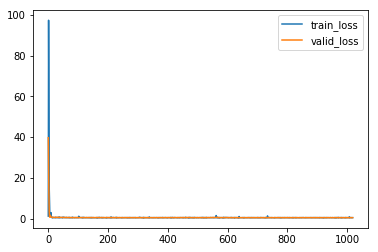

In [5]:
import matplotlib.pyplot as mplot

mplot.plot(train_loss, label='train_loss')
mplot.plot(valid_loss, label='valid_loss')
mplot.legend()
mplot.show()

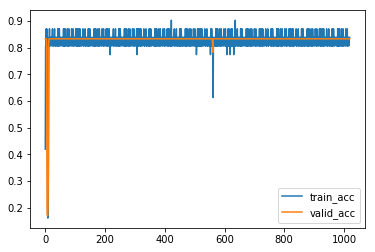

In [6]:
# import matplotlib.pyplot as mplot

mplot.plot(train_acc, label='train_acc')
mplot.plot(valid_acc, label='valid_acc')
mplot.legend()
mplot.show()